In [1]:
import numpy as np
from itertools import product
from pysm3.models import Model, CMBLensed

In [2]:
ps_c1 = "demo_powerspectra/c1_ps.dat"
ps_c1_with_l01 = "demo_powerspectra/c1_ps_l01.dat"
ps_camb = "demo_powerspectra/camb_ps.dat"  # Only used to demonstrate that CAMB output includes L=0,1

# Problem

The method duplicates [lines 290-338 from pysm/src/pysm3/models/cmb.py](./src/pysm3/models/cmb.py#L290C1-L338C20).

In [3]:
def orig_method(self):
    synlmax = 8 * self.nside  # this used to be user-defined.
    data = self.cmb_spectra
    lmax_cl = len(data[0]) + 1

    ell = np.arange(int(lmax_cl + 1))
    synlmax = min(synlmax, ell[-1])

    # Reading input spectra in CAMB format. CAMB outputs l(l+1)/2pi hence the corrections.
    cl_tebp_arr = np.zeros([10, lmax_cl + 1])
    cl_tebp_arr[0, 2:] = 2 * np.pi * data[1] / (ell[2:] * (ell[2:] + 1))  # TT
    cl_tebp_arr[1, 2:] = 2 * np.pi * data[2] / (ell[2:] * (ell[2:] + 1))  # EE
    cl_tebp_arr[2, 2:] = 2 * np.pi * data[3] / (ell[2:] * (ell[2:] + 1))  # BB
    cl_tebp_arr[4, 2:] = 2 * np.pi * data[4] / (ell[2:] * (ell[2:] + 1))  # TE
    cl_tebp_arr[5, :] = np.zeros(lmax_cl + 1)  # EB
    cl_tebp_arr[7, :] = np.zeros(lmax_cl + 1)  # TB

    if self.apply_delens:  # This case can be ignored for issue 212
        cl_tebp_arr[3, 2:] = (
            2
            * np.pi
            * data[5]
            * self.delensing_ells[1]
            / (ell[2:] * (ell[2:] + 1)) ** 2
        )  # PP
        cl_tebp_arr[6, :] = np.zeros(lmax_cl + 1)  # BP
        cl_tebp_arr[8, 2:] = (
            2
            * np.pi
            * data[7]
            * np.sqrt(self.delensing_ells[1])
            / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # EP
        cl_tebp_arr[9, 2:] = (
            2
            * np.pi
            * data[6]
            * np.sqrt(self.delensing_ells[1])
            / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # TP
    else:
        cl_tebp_arr[3, 2:] = (
            2 * np.pi * data[5] / (ell[2:] * (ell[2:] + 1)) ** 2
        )  # PP
        cl_tebp_arr[6, :] = np.zeros(lmax_cl + 1)  # BP
        cl_tebp_arr[8, 2:] = (
            2 * np.pi * data[7] / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # EP
        cl_tebp_arr[9, 2:] = (
            2 * np.pi * data[6] / (ell[2:] * (ell[2:] + 1)) ** 1.5
        )  # TP

    ############################### End of copied portion.
    return cl_tebp_arr

I need a placeholder object to act as "`self`."

In [4]:
class SurrogateCMBLensed(Model):
    def __init__(self, ps_file, apply_delens=False, nside=2048):
        super().__init__(nside=nside)
        self.nside = nside
        self.cmb_seed = 8675309
        self.cmb_spectra = self.read_txt(ps_file, unpack=True)
        self.apply_delens = apply_delens
        # self.delensing_ells = self.read_txt(delensing_ells_fp)  # Change needed!
        self._map = None

When using preset string `c1`, the power spectra are loaded from (renamed, because of astropy) [c1_powerspectra.txt](./demo_powerspectra/c1_powerspectra.txt). Here's the first five rows of that file (`ps_c1`):

In [5]:
with open(ps_c1, "r") as f:
    for i in range(5):
        print(f.readline().rstrip())

#    L    TT             EE             BB             TE             PP             TP             EP
     2    0.10678E+04    0.34282E-01    0.00000E+00    0.27104E+01    0.49277E-07    0.32326E-02   -0.12847E-04
     3    0.10029E+04    0.46186E-01    0.00000E+00    0.31328E+01    0.60013E-07    0.32173E-02   -0.14138E-04
     4    0.94274E+03    0.42475E-01    0.00000E+00    0.30100E+01    0.69182E-07    0.31297E-02   -0.12452E-04
     5    0.89773E+03    0.30431E-01    0.00000E+00    0.26210E+01    0.77138E-07    0.30167E-02   -0.91211E-05


CAMB produces output with rows for $\ell = 0$ and $\ell = 1$. An example file is [camb_powerspectra.txt](./demo_powerspectra/camb_powerspectra.txt). This is stated in the [CAMB documentation](https://camb.readthedocs.io/en/latest/results.html#camb.results.CAMBdata.get_cmb_power_spectra).

In [6]:
with open(ps_camb, "r") as f:
    for i in range(5):
        print(f.readline().rstrip())

#  L TT            EE            BB            TE            PP            PT            PE
   0 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   1 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   2 1.0825953e+03 1.4746664e-01 1.4796820e-07 6.6772338e+00 5.2118790e-08 2.7735919e-03 -2.5091173e-05
   3 1.0465663e+03 3.9779316e-01 2.9968791e-07 1.0461787e+01 6.2924300e-08 2.8439773e-03 -3.7494399e-05


So, for comparison, I've added two such lines to the power spectra used with `c1` ([c1_powerspectra_l01.txt](./demo_powerspectra/c1_powerspectra_l01.txt)). I show 7 rows of (`ps_c1_l01`):

In [7]:
with open(ps_c1_with_l01, "r") as f:
    for i in range(7):
        print(f.readline().rstrip())

#    L    TT             EE             BB             TE             PP             TP             EP
     0    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00
     1    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00
     2    0.10678E+04    0.34282E-01    0.00000E+00    0.27104E+01    0.49277E-07    0.32326E-02   -0.12847E-04
     3    0.10029E+04    0.46186E-01    0.00000E+00    0.31328E+01    0.60013E-07    0.32173E-02   -0.14138E-04
     4    0.94274E+03    0.42475E-01    0.00000E+00    0.30100E+01    0.69182E-07    0.31297E-02   -0.12452E-04
     5    0.89773E+03    0.30431E-01    0.00000E+00    0.26210E+01    0.77138E-07    0.30167E-02   -0.91211E-05


I compare how `cl_tebp_arr` is built from `ps_c1` and `ps_c1_l01`:

In [8]:
tebp_orig_wout_l01 = orig_method(SurrogateCMBLensed(ps_c1))
tebp_orig_with_l01 = orig_method(SurrogateCMBLensed(ps_c1_with_l01))

In [9]:
tebp_orig_wout_l01.shape, tebp_orig_with_l01.shape  # Shapes are expected to be different (two rows have been added to the latter)

((10, 2201), (10, 2203))

I print the numbers - it shows what's going on, but not as clearly. You can also see that because the normalization factors involve $\ell$, the $C_\ell$ values change; they aren't just shifted.

In [10]:
np.set_printoptions(precision=2, suppress=True, formatter={'float': '{:.2e}'.format}, linewidth=100)

def compare_tebp_num(tebps, labels, show_lmax=5):
    for i in range(show_lmax):
        print()
        for label, tebp in zip(labels, tebps):
            print(f"{label}: {tebp[:, i]}")

In [11]:
compare_tebp_num([tebp_orig_wout_l01, tebp_orig_with_l01], ["wout l01", "with l01"])


wout l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [1.12e+03 3.59e-02 0.00e+00 8.60e-09 2.84e+00 0.00e+00 0.00e+00 0.00e+00 -5.49e-06 1.38e-03]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [5.25e+02 2.42e-02 0.00e+00 2.62e-09 1.64e+00 0.00e+00 0.00e+00 0.00e+00 -2.14e-06 4.86e-04]
with l01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

wout l01: [2.96e+02 1.33e-02 0.00e+00 1.09e-09 9.46e-01 0.00e+00 0.00e+00 0.00e+00 -8.75e-07 2.20e-04]
with l01: [3.35e+02 1.08e-02 0.00e+00 7.74e-10 8.51e-01 0.00e+00 0.00e+00 

I plot them. I have to convert back from $C_\ell$ to the normalized form, so it's easier to see.

In [12]:
def build_tebp_dl2cl_scale(tebp_shape):
    use_lmax = tebp_shape[1] - 1
    ell = np.arange(use_lmax + 1)
    ell[0] = 1

    scale = np.zeros([10, use_lmax + 1])
    scale[0] = 2 * np.pi / (ell * (ell + 1))         # TT
    scale[1] = 2 * np.pi / (ell * (ell + 1))         # EE
    scale[2] = 2 * np.pi / (ell * (ell + 1))         # BB
    scale[3] = 2 * np.pi / (ell * (ell + 1)) ** 2    # PP
    scale[4] = 2 * np.pi / (ell * (ell + 1))         # TE
    scale[5] = 2 * np.pi / (ell * (ell + 1))         # EB
    scale[6] = 2 * np.pi / (ell * (ell + 1))         # BP
    scale[7] = 2 * np.pi / (ell * (ell + 1))         # TB
    scale[8] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # EP
    scale[9] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # TP

    return scale

def cl2dl_tebp(tebp):
    scale = build_tebp_dl2cl_scale(tebp.shape)
    return tebp / scale

In [13]:
tebp_orig_with_l01_dl = cl2dl_tebp(tebp_orig_with_l01)
tebp_orig_wout_l01_dl = cl2dl_tebp(tebp_orig_wout_l01)

In [14]:
import matplotlib.pyplot as plt

def compare_tebp(tebps, labels, show_lmax=10):
    tebp_idcs = ["TT", "EE", "BB", "PP", "TE", "EB", "BP", "TB", "EP", "TP"]

    for i in range(10):
        if i in [2, 5, 6, 7]:
            continue
        plt.figure()
        for j, tebp in enumerate(tebps):
            plt.plot(tebp[i][:show_lmax], label=labels[j], 
                    #  linewidth=(3-j), 
                     marker=str(j+1), markersize=10)
        plt.title(f"idx {i}, {tebp_idcs[i]}")
        plt.legend()
        plt.show()

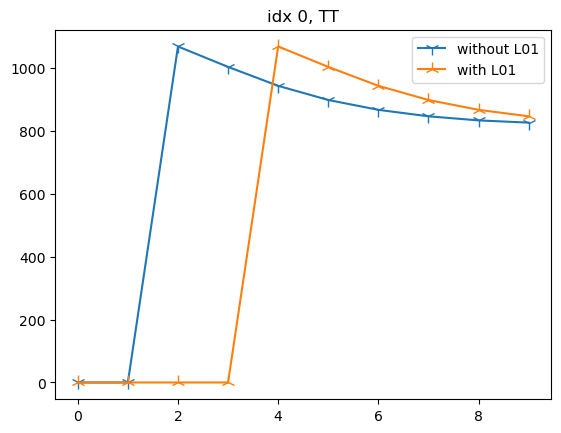

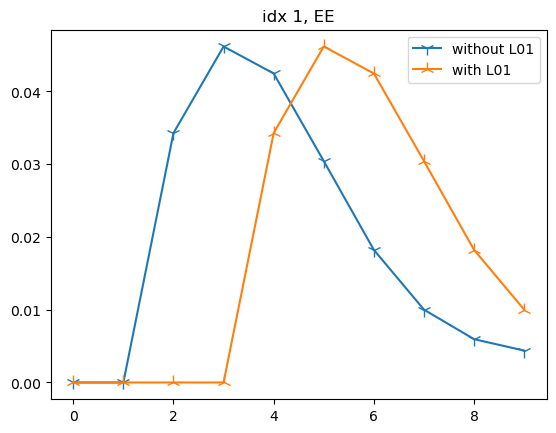

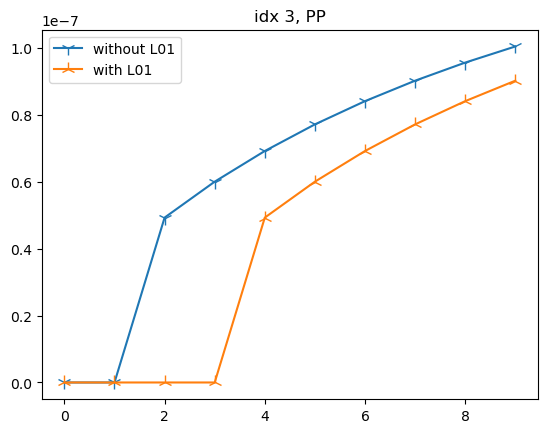

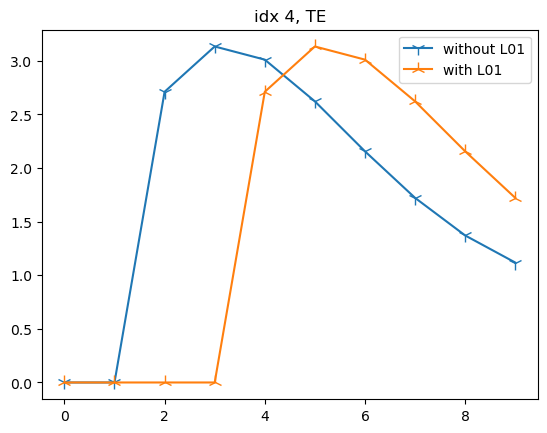

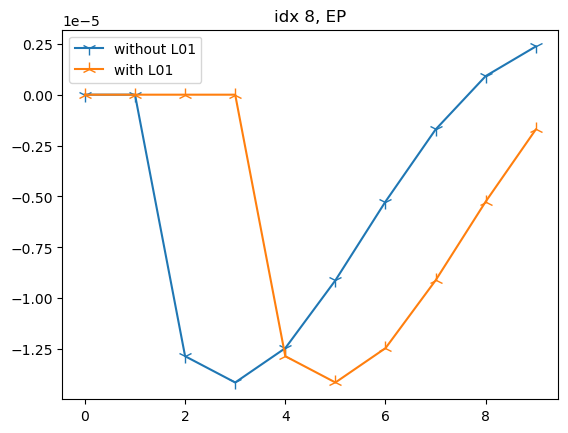

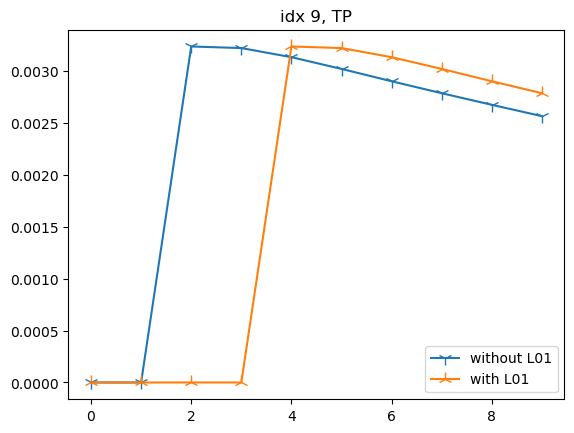

In [15]:
compare_tebp([tebp_orig_wout_l01_dl, tebp_orig_with_l01_dl], ["without L01", "with L01"], 10)

# Rewriting the method

The original method does two things:
- Rearrange columns from CAMB output (L, TT, EE, BB, TE, PP, TP, EP) to new order (TT, EE, BB, PP, TE, EB, BP, TB, EP, TP)
- Normalizes by factors of $\ell(\ell+1)$ and $2\pi$. Columns with polarization have additional $\sqrt{\ell(\ell+1)}$ applied.

I separated those two steps. It may be prudent to make those into individual functions. I've marked them for clarity here; I would not include that in the repo.

In [16]:
def rewritten_method(self):
    """
    Assumptions:
    - Multipoles are in order, non-repeating, continuous
    - CAMB output is L, TT, EE, BB, TE, PP, TP, EP
    Old:
    - Multipoles start at 2
    New:
    - Multipoles start at either 0 or 2
    """
    src_dl = self.cmb_spectra
    src_lmax = int(src_dl[0][-1])  # Last value in the first column (L)

    if src_dl[0][0] == 2:
        # Multipoles start at 2 (old assumption)
        # Insert zeros and clip to use_lmax
        temp_ps = np.zeros((len(src_dl), src_lmax + 1))
        temp_ps[:, 2:] = src_dl[:, :src_lmax + 1]
        dl = temp_ps
    else:
        # Multipoles start at 0
        # Clip to use_lmax
        dl = src_dl[:, :src_lmax + 1]

    #########################
    # Changing column order; adding zeros for columns with no cross-spectra
    #########################

    cl_tebp_arr = np.zeros([10, src_lmax + 1])
    cl_tebp_arr[0] = dl[1]  # TT
    cl_tebp_arr[1] = dl[2]  # EE
    cl_tebp_arr[2] = dl[3]  # BB
    cl_tebp_arr[3] = dl[5]  # PP
    cl_tebp_arr[4] = dl[4]  # TE
    cl_tebp_arr[5] = 0      # EB
    cl_tebp_arr[6] = 0      # BP
    cl_tebp_arr[7] = 0      # TB
    cl_tebp_arr[8] = dl[7]  # EP
    cl_tebp_arr[9] = dl[6]  # TP

    #########################
    # Normalize
    #########################

    # ell = np.arange(src_lmax + 1)
    # ell_fac = ell * (ell + 1)
    # ell_fac[0] = 1  # Avoid division by zero

    # # Most of the columns have a factor of 2 * pi / (ell * (ell + 1))
    # cl_tebp_arr    *= 2 * np.pi / ell_fac

    # # Polarization has additional factors of ell
    # cl_tebp_arr[3] /= ell_fac         # PP
    # cl_tebp_arr[8] /= ell_fac ** 0.5  # EP
    # cl_tebp_arr[9] /= ell_fac ** 0.5  # TP

    scale = build_tebp_dl2cl_scale(cl_tebp_arr.shape)
    cl_tebp_arr *= scale

    # Set values to zero, as the remaining code was tested in this condition
    cl_tebp_arr[:, 0:2] = 0

    return cl_tebp_arr

In [17]:
tebp_rewr_wout_l01 = rewritten_method(SurrogateCMBLensed(ps_c1))
tebp_rewr_with_l01 = rewritten_method(SurrogateCMBLensed(ps_c1_with_l01))

tebp_rewr_wout_l01_dl = cl2dl_tebp(tebp_rewr_wout_l01)
tebp_rewr_with_l01_dl = cl2dl_tebp(tebp_rewr_with_l01)

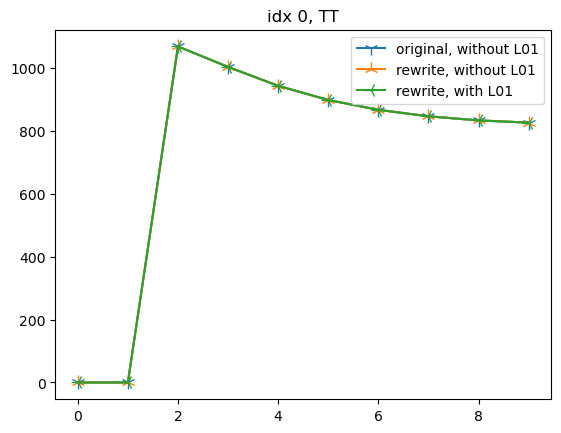

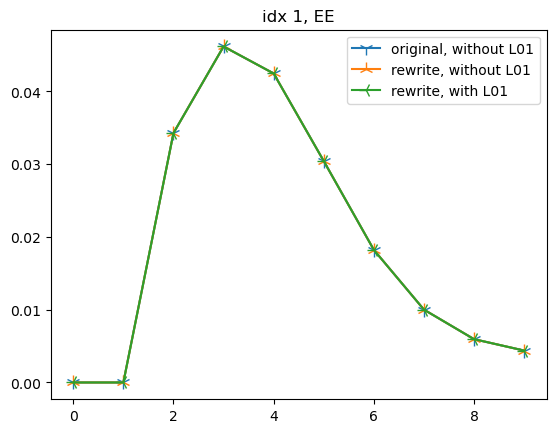

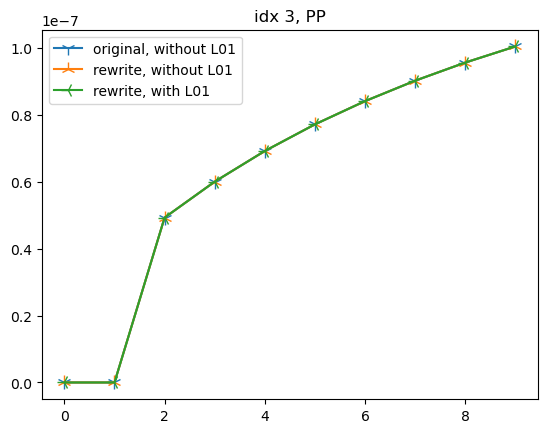

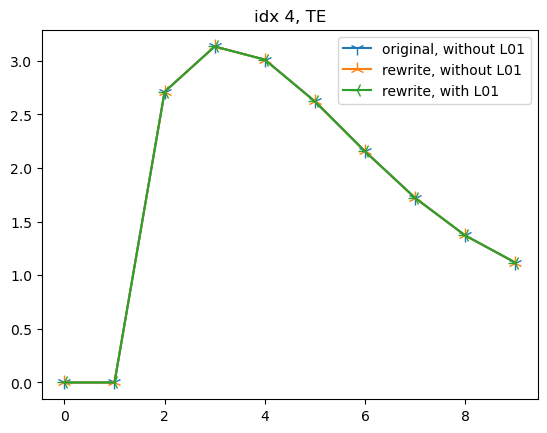

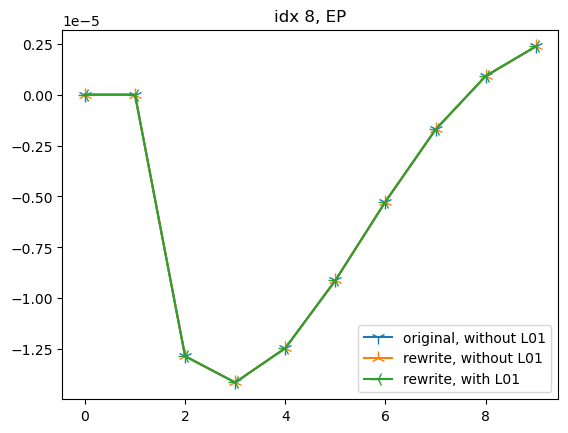

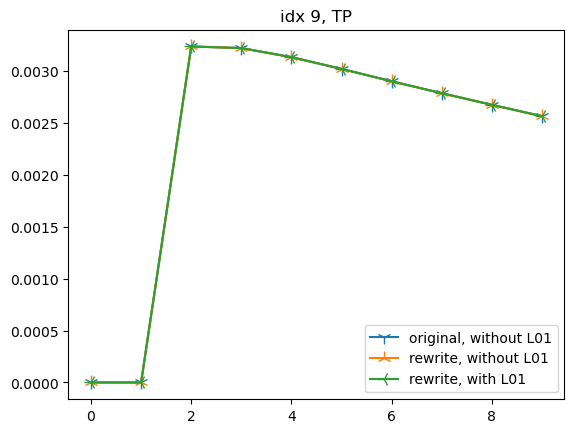

In [18]:
compare_tebp([
              tebp_orig_wout_l01_dl,
              tebp_rewr_wout_l01_dl,
              tebp_rewr_with_l01_dl
              ], 
              [
              "original, without L01",
              "rewrite, without L01",
              "rewrite, with L01"
              ], 10)

In [19]:
compare_tebp_num([
              tebp_orig_wout_l01,
              tebp_orig_with_l01,
              tebp_rewr_wout_l01,
              tebp_rewr_with_l01
              ], 
              [
              "original, without L01",
              "original, with    L01",
              "rewrite , without L01",
              "rewrite , with    L01"
              ])


original, without L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
original, with    L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
rewrite , without L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
rewrite , with    L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

original, without L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
original, with    L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
rewrite , without L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
rewrite , with    L01: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]

original, without L01: [1.12e+03 3.59e-02 0.00e+00 8.60e-09 2.84e+00 0.00e+00

Compare the sizes of the TEBP arrays. Only the case where two lines were added and the original method was used is different.

In [20]:
print(tebp_orig_wout_l01.shape, tebp_orig_with_l01.shape)
print(tebp_rewr_wout_l01.shape, tebp_rewr_with_l01.shape)

(10, 2201) (10, 2203)
(10, 2201) (10, 2201)


In [21]:
print(np.allclose(tebp_orig_wout_l01, tebp_rewr_wout_l01))
print(np.allclose(tebp_orig_wout_l01, tebp_rewr_with_l01))

True
True


There is some small amount of numerical error. I believe this is due to order of operations changes.

In [22]:
delta = tebp_orig_wout_l01 - tebp_rewr_with_l01
delta[:, 2]

array([0.00e+00, 0.00e+00, 0.00e+00, 1.65e-24, 4.44e-16, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       2.17e-19])

# Full pipeline

In [23]:
import healpy as hp
from pysm3.models.cmb import simulate_tebp_correlated, offset_pos, taylor_interpol_iter, apply_rotation

In [24]:
def run_taylens_orig(self):
    synlmax = 8 * self.nside  # this used to be user-defined.
    data = self.cmb_spectra
    lmax_cl = len(data[0]) + 1
    ell = np.arange(int(lmax_cl + 1))
    synlmax = min(synlmax, ell[-1])

    cl_tebp_arr = orig_method(self)

    print(synlmax, cl_tebp_arr.shape)

    # Coordinates of healpix pixel centers
    ipos = np.array(hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))))

    # Simulate a CMB and lensing field
    cmb, aphi = simulate_tebp_correlated(
        cl_tebp_arr, self.nside, synlmax, self.cmb_seed
    )

    if cmb.ndim == 1:
        cmb = np.reshape(cmb, [1, cmb.size])

    # Compute the offset positions
    phi, phi_dtheta, phi_dphi = hp.alm2map_der1(aphi, self.nside, lmax=synlmax)

    del aphi

    opos, rot = offset_pos(
        ipos, phi_dtheta, phi_dphi, pol=True, geodesic=False
    )  # geodesic used to be used defined.
    del phi, phi_dtheta, phi_dphi

    # Interpolate maps one at a time
    maps = []
    for comp in cmb:
        for m in taylor_interpol_iter(
            comp, opos, 3, verbose=False, lmax=None
        ):  # lmax here needs to be fixed. order of taylor expansion is fixed to 3.
            pass
        maps.append(m)
    del opos, cmb
    return np.array(apply_rotation(maps, rot))

In [25]:
def run_taylens_rewrite(self):
    synlmax = 8 * self.nside  # this used to be user-defined.

    src_dl = self.cmb_spectra
    src_lmax = int(src_dl[0][-1])  # Last value in the first column (L)

    synlmax = min(synlmax, src_lmax)

    cl_tebp_arr = rewritten_method(self)

    print(synlmax, cl_tebp_arr.shape)

    # Coordinates of healpix pixel centers
    ipos = np.array(hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))))

    # Simulate a CMB and lensing field
    # NOTE: This is the only use of cl_tebp_arr; synlmax can be simplified.
    # TODO: Check this
    cmb, aphi = simulate_tebp_correlated(
        cl_tebp_arr, self.nside, synlmax, self.cmb_seed
    )

    if cmb.ndim == 1:
        cmb = np.reshape(cmb, [1, cmb.size])

    # Compute the offset positions
    phi, phi_dtheta, phi_dphi = hp.alm2map_der1(aphi, self.nside, lmax=synlmax)

    del aphi

    opos, rot = offset_pos(
        ipos, phi_dtheta, phi_dphi, pol=True, geodesic=False
    )  # geodesic used to be used defined.
    del phi, phi_dtheta, phi_dphi

    # Interpolate maps one at a time
    maps = []
    for comp in cmb:
        for m in taylor_interpol_iter(
            comp, opos, 3, verbose=False, lmax=None
        ):  # lmax here needs to be fixed. order of taylor expansion is fixed to 3.
            pass
        maps.append(m)
    del opos, cmb
    return np.array(apply_rotation(maps, rot))

In [26]:
map_orig_wout_l01 = run_taylens_orig(SurrogateCMBLensed(ps_c1, nside=128))
map_orig_with_l01 = run_taylens_orig(SurrogateCMBLensed(ps_c1_with_l01, nside=128))
map_rewr_wout_l01 = run_taylens_rewrite(SurrogateCMBLensed(ps_c1, nside=128))
map_rewr_with_l01 = run_taylens_rewrite(SurrogateCMBLensed(ps_c1_with_l01, nside=128))

1024 (10, 2201)
1024 (10, 2203)
1024 (10, 2201)
1024 (10, 2201)


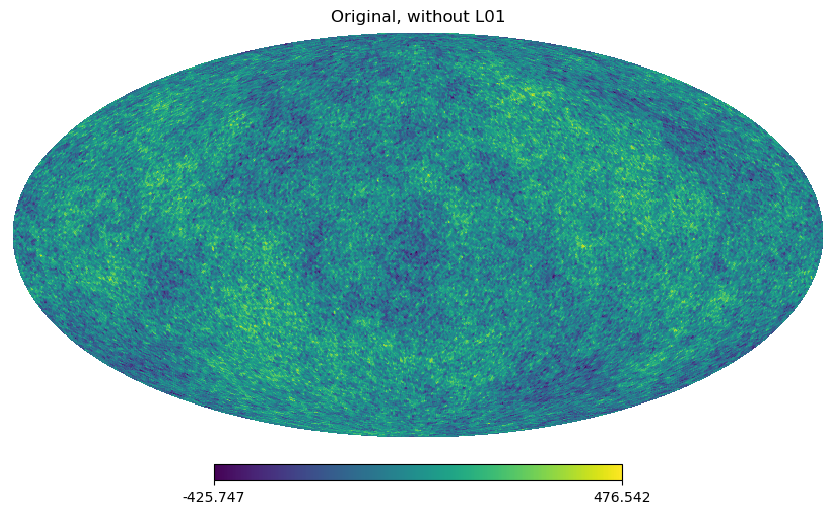

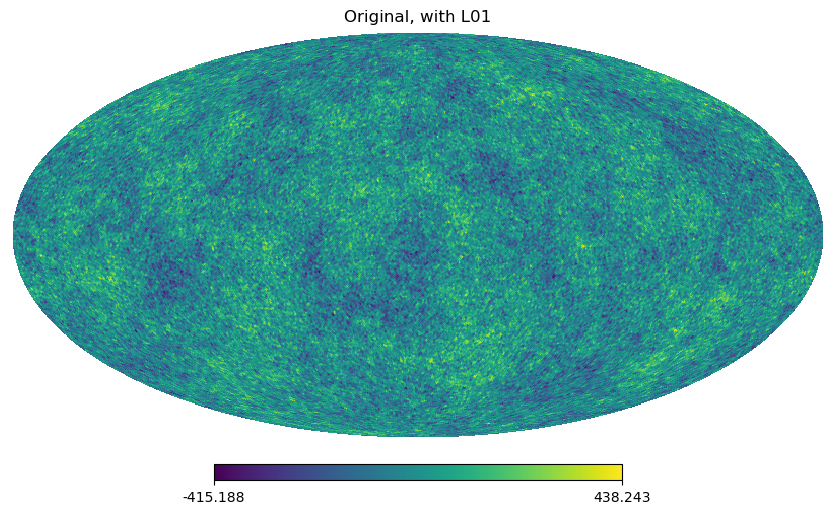

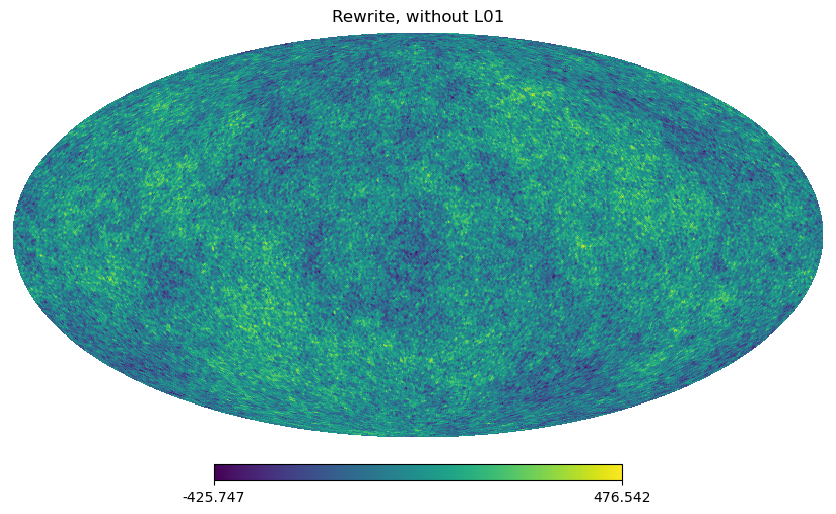

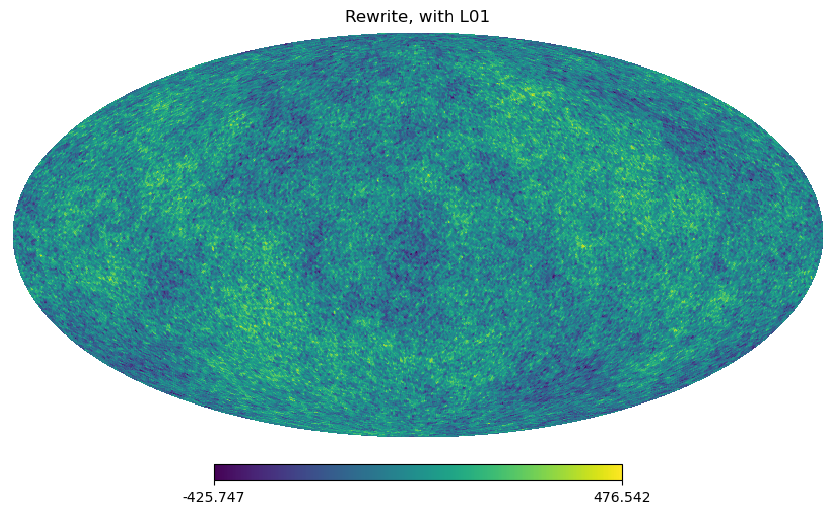

In [27]:
hp.mollview(map_orig_wout_l01[0], title="Original, without L01")
hp.mollview(map_orig_with_l01[0], title="Original, with L01")
hp.mollview(map_rewr_wout_l01[0], title="Rewrite, without L01")
hp.mollview(map_rewr_with_l01[0], title="Rewrite, with L01")

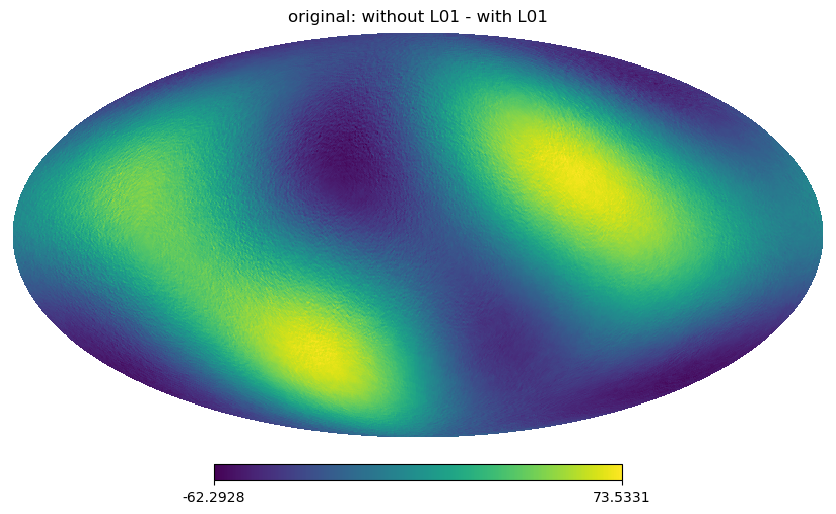

In [28]:
hp.mollview(map_orig_wout_l01[0] - map_orig_with_l01[0], title="original: without L01 - with L01")  # pretty! But... wrong, even outside the monopole and dipole.

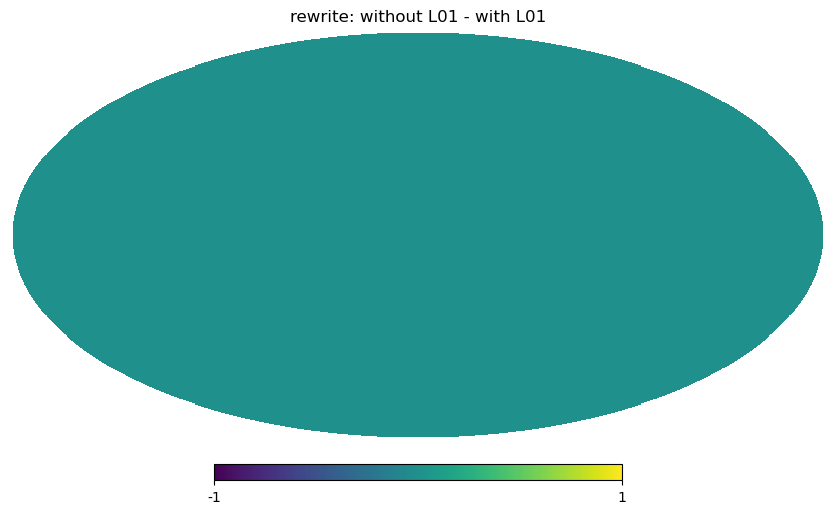

In [29]:
hp.mollview(map_rewr_wout_l01[0] - map_rewr_with_l01[0], title="rewrite: without L01 - with L01")

I believe the small differences (OTO 1e-12 / 1) are due to the numerical error above.

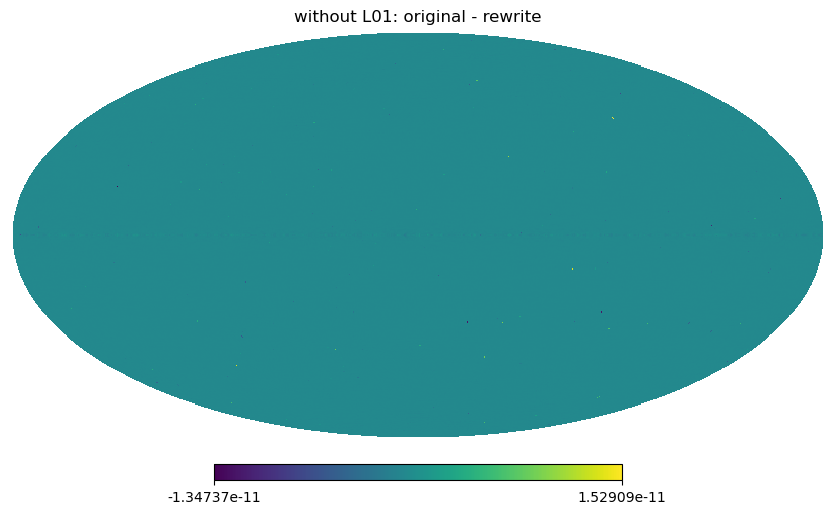

In [30]:
hp.mollview(map_orig_wout_l01[0] - map_rewr_with_l01[0], title="without L01: original - rewrite")

# Proposed new CMBLensed (addressing Issue 212 ONLY)

In [31]:
import pysm3.units as u  # so it doesn't crash
from pysm3.models import CMBMap

def build_tebp_dl2cl_scale(tebp_shape):
    use_lmax = tebp_shape[1] - 1
    ell = np.arange(use_lmax + 1)
    ell[0] = 1            # Avoid division by zero errors
                          #   This would only affect L=0,
                          #   which will be set to 0.

    scale = np.zeros([10, use_lmax + 1])
    scale[0] = 2 * np.pi / (ell * (ell + 1))         # TT
    scale[1] = 2 * np.pi / (ell * (ell + 1))         # EE
    scale[2] = 2 * np.pi / (ell * (ell + 1))         # BB
    scale[3] = 2 * np.pi / (ell * (ell + 1)) ** 2    # PP
    scale[4] = 2 * np.pi / (ell * (ell + 1))         # TE
    scale[5] = 2 * np.pi / (ell * (ell + 1))         # EB
    scale[6] = 2 * np.pi / (ell * (ell + 1))         # BP
    scale[7] = 2 * np.pi / (ell * (ell + 1))         # TB
    scale[8] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # EP
    scale[9] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # TP

    return scale

def camb2tebp(camb_dl):
    """
    Assumptions:
    - Multipoles are in order, non-repeating, continuous
    - CAMB output is L, TT, EE, BB, TE, PP, TP, EP
    - Multipoles start at either 0 or 2
    """
    src_lmax = int(camb_dl[0][-1])  # Last value in the first column (L)

    if camb_dl[0][0] == 2:
        # Multipoles start at 2 (old assumption)
        # Insert zeros and clip to use_lmax
        temp_ps = np.zeros((len(camb_dl), src_lmax + 1))
        temp_ps[:, 2:] = camb_dl[:, :src_lmax + 1]
        dl = temp_ps
    elif camb_dl[0][0] == 0:
        # Multipoles start at 0
        # Clip to use_lmax
        dl = camb_dl[:, :src_lmax + 1]
    else:
        # I think the user would want to know and adjust
        raise ValueError("Multipoles must start at 0 or 2")

    cl_tebp_arr = np.zeros([10, src_lmax + 1])
    cl_tebp_arr[0] = dl[1]  # TT
    cl_tebp_arr[1] = dl[2]  # EE
    cl_tebp_arr[2] = dl[3]  # BB
    cl_tebp_arr[3] = dl[5]  # PP
    cl_tebp_arr[4] = dl[4]  # TE
    cl_tebp_arr[5] = 0      # EB
    cl_tebp_arr[6] = 0      # BP
    cl_tebp_arr[7] = 0      # TB
    cl_tebp_arr[8] = dl[7]  # EP
    cl_tebp_arr[9] = dl[6]  # TP

    scale = build_tebp_dl2cl_scale(cl_tebp_arr.shape)
    cl_tebp_arr *= scale

    # Set values to zero, as the remaining code was tested in this condition
    cl_tebp_arr[:, 0:2] = 0

    return cl_tebp_arr

class CMBLensed(CMBMap):
    # intherit from CMBMap so we get the `get_emission` method
    def __init__(
        self,
        nside,
        cmb_spectra,
        max_nside=None,
        cmb_seed=None,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    ):
        """Lensed CMB

        Takes an input unlensed CMB and lensing spectrum from CAMB and uses
        Taylens to apply lensing, it optionally simulates delensing by
        suppressing the lensing power at specific scales with the user
        provided `delensing_ells`.

        Parameters
        ----------

        cmb_spectra : path
            Input text file from CAMB, spectra unlensed
        cmb_seed : int
            Numpy random seed for synfast, set to None for a random seed
        apply_delens : bool
            If true, simulate delensing with taylens
        delensing_ells : path
            Space delimited file with ells in the first columns and suppression
            factor (1 for no suppression) in the second column
        """
        try:
            super().__init__(nside=nside, max_nside=max_nside, map_dist=map_dist)
        except ValueError:
            pass  # suppress exception about not providing any input map
        self.cmb_spectra = self.read_txt(cmb_spectra, unpack=True)
        self.cmb_seed = cmb_seed
        self.apply_delens = apply_delens
        self.delensing_ells = (
            None if delensing_ells is None else self.read_txt(delensing_ells)
        )
        self.map = u.Quantity(self.run_taylens(), unit=u.uK_CMB, copy=False)

    def run_taylens(self):
        """Returns CMB (T, Q, U) maps as a function of observing frequency, nu.

        This code is extracted from the taylens code (reference).

        :return: function -- CMB maps.
        """
        synlmax = 8 * self.nside  # this used to be user-defined.
        data = self.cmb_spectra
        lmax_cl = len(data[0]) + 1
        ell = np.arange(int(lmax_cl + 1))
        synlmax = min(synlmax, ell[-1])

        # Convert the input spectra to the format used by taylens
        cl_tebp_arr = camb2tebp(data)

        if self.apply_delens:
            raise NotImplementedError("Delensing is not implemented yet.")

        # Coordinates of healpix pixel centers
        ipos = np.array(hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))))

        # Simulate a CMB and lensing field
        cmb, aphi = simulate_tebp_correlated(
            cl_tebp_arr, self.nside, synlmax, self.cmb_seed
        )

        if cmb.ndim == 1:
            cmb = np.reshape(cmb, [1, cmb.size])

        # Compute the offset positions
        phi, phi_dtheta, phi_dphi = hp.alm2map_der1(aphi, self.nside, lmax=synlmax)

        del aphi

        opos, rot = offset_pos(
            ipos, phi_dtheta, phi_dphi, pol=True, geodesic=False
        )  # geodesic used to be used defined.
        del phi, phi_dtheta, phi_dphi

        # Interpolate maps one at a time
        maps = []
        for comp in cmb:
            for m in taylor_interpol_iter(
                comp, opos, 3, verbose=False, lmax=None
            ):  # lmax here needs to be fixed. order of taylor expansion is fixed to 3.
                pass
            maps.append(m)
        del opos, cmb
        return np.array(apply_rotation(maps, rot))